# Clickbait 2.0
This is a second more serious attempt at cracking the clickbait problem. The idea is to make 1 step back to make 2 steps forward. 
Let's first do text clickbait classification, which will help us with labeling in the future.

In [102]:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    np.random.seed(179)
    print(tf.__version__) # 2.x required

2.1.0


In [33]:
cb_filename = "data/clickbait_data"
nocb_filename = "data/non_clickbait_data"

In [105]:
def load_data(filename, cb_label):
    # cb_label: 1 if clickbait, 0 if not 
    with open(filename, "r") as f:
        file = f.read()
    lines = file.split('\n\n')
    # Clean from line breaks and empty entries
    lines = [line.replace('\n', ' ') for line in lines if len(line) > 0]
    
    lines = pd.DataFrame({'text':lines}) # Create Pandas dataFrame
    lines['Clickbait'] = cb_label
    
    return lines


cb_df = load_data(cb_filename, 1)
nocb_df = load_data(nocb_filename, 0)

df = pd.concat([cb_df, nocb_df], axis=0).reset_index(drop=True).sample(frac=1)
df.head()

,text,Clickbait
24400,Thai Queen attends protester cremation as repo...,0
12834,13 Dogs Who Look Just Like The 2016 Presidenti...,1
3587,We Know If You're Hungry Based On Your Reactio...,1
14929,Which Albus Dumbledore Quote Should Be Your Li...,1
16921,Corporate Jets Sitting Out the Super Bowl Germ...,0


In [121]:
from sklearn.model_selection import train_test_split

def split_data(df):
    temp = train_test_split(df)
    train_text = temp[0]['text'].values
    train_label = temp[0]['Clickbait'].values
    test_text = temp[1]['text'].values
    test_label = temp[1]['Clickbait'].values
    return (train_text, train_label), (test_text, test_label)
    
(train_text, train_label), (test_text, test_label) = split_data(df)

In [104]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

In [126]:
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 124,659,329
Trainable params: 16,641
Non-trainable params: 124,642,688
_________________________________________________________________


In [127]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [131]:
history = model.fit(train_text, train_label, epochs=5, validation_data=(test_text, test_label))

Train on 19500 samples, validate on 6500 samples
Epoch 1/5
19500/19500 [==============================] - 1s 65us/sample - loss: 0.0089 - accuracy: 0.9969 - val_loss: 0.0146 - val_accuracy: 0.9943
Epoch 2/5
19500/19500 [==============================] - 1s 63us/sample - loss: 0.0081 - accuracy: 0.9971 - val_loss: 0.0138 - val_accuracy: 0.9949
Epoch 3/5
19500/19500 [==============================] - 1s 62us/sample - loss: 0.0072 - accuracy: 0.9974 - val_loss: 0.0182 - val_accuracy: 0.9937
Epoch 4/5
19500/19500 [==============================] - 1s 62us/sample - loss: 0.0069 - accuracy: 0.9975 - val_loss: 0.0138 - val_accuracy: 0.9952
Epoch 5/5
19500/19500 [==============================] - 1s 62us/sample - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.0140 - val_accuracy: 0.9951


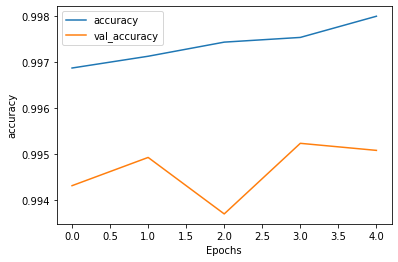

In [132]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, "accuracy")

In [195]:
model.predict(["regular news", 
                "Barack Obama did something amazing",
                "MUST WATCH", 
                "OMG", 
              "17 ways why you must do that thing",
              "100 Times ‘Stop Clickbait’ Hilariously Summarized Clickbait Articles And Saved You A Click (New Pics)",
              "10 ways to get rich",
               "10 WAYS TO GET RICH",
               "You will never see it",
               "Surprising Our Mom With EPIC BACKYARD MAKEOVER",
               "so i shaved my head",
               "Going to the Weed Research Lab in Colorado",
               "Do All Millionaires Think The Same?",
               "Buying The 7 Strangest Things Wish Recommended Me!",
               "5 Seconds of Summer - Spilling the Quarantea (Full Video)",
               "NY Gov. Andrew Cuomo Holds Coronavirus Briefing | NBC News",
               "Trump proposes ban on legal immigration over coronavirus crisis",
               "CDC director says possible second Covid-19 wave could be worse",
               "Gupta reacts to Georgia's safety guidelines: It's ridiculous",
               "Trump: ‘We Don’t Know’ About North Korean Leader Kim's Health",
               "New study shows hydroxychloroquine didn't work against Covid-19"
              ]) > 0.5

array([[False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False]])

In [165]:
model.save('pretrained_dense.h5')

Links and papers that seemed useful:

[Misleading Online Content: Recognizing Clickbait as "False News"](https://www.researchgate.net/profile/Victoria_Rubin/publication/283721117_Misleading_Online_Content_Recognizing_Clickbait_as_False_News/links/5644c4b108ae54697fb813d1/Misleading-Online-Content-Recognizing-Clickbait-as-False-News.pdf)

[nnlm-en-dim128 Sentence Embedding model by Google](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
